# Model 001 BasicVm: Coupled Steady-State Solution

This model shows example usage of the BasicVm model from the TerrainBento package.

BasicVm modifies the Basic model by allowing a variable drainage-area exponent, $m$:

$\frac{\partial \eta}{\partial t} = - KA^m S + D\nabla^2 \eta$

Note that the units of $K$ depend on $m$, so that the value of $K$ used in BasicVm cannot be meaningfully compared to $K$ used in models with a fixed area exponent of 1/2, unless of course $m$ happens to equal 1/2.

Refer to [REF MANUSCRIPT] for the definition of all symbols. 

This notebook (a) shows the initialization and running of this model, (b) saves a NetCDF file of the topography, which we will use to make an oblique Paraview image of the landscape, and (c) creates a slope-area plot at steady state.

In [1]:
# import required modules
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
%matplotlib inline

from landlab import imshow_grid
from landlab.io.netcdf import write_netcdf

from terrainbento import Basic

In [2]:
# create the parameter dictionary needed to instantiate the model 
# all parameters used are specified in this notebook block

params = {'number_of_node_rows' : 100,
          'number_of_node_columns' : 160,
          'node_spacing' : 10.0,
          'east_boundary_closed' : False,
          'north_boundary_closed' : False,
          'west_boundary_closed' : False,
          'south_boundary_closed' : False,
          'dt' : 10.0,
          'K_sp' : 0.001,
          'm_sp' : 0.25,
          'n_sp' : 1.0,
          'linear_diffusivity' : 0.01,
          'outlet_lowering_rate' : 0.0005,
          'output_filename': 'model_000_output'
}

In [3]:
# initialize the model by passing the parameter dictionary
model = Basic(params=params)

# set a tolerance for determining steady state
tolerance = 0.0001

In [4]:
# run the model, it will take 1,550,000 years

# set dt and initialize the elapsed_time variable
dt = params['dt']
elapsed_time = 0 

# initialize a variable to identify if steady state has been reached
keep_running = True

# run the model until stead state has been reached. 
while keep_running == True:
    
    # save the pre-model-step topography of the core nodes to assess steady state. 
    pre_topo = model.grid.at_node['topographic__elevation'][model.grid.core_nodes]
    
    # run the model one step
    model.run_one_step(dt)
    
    # save the post-model step topography of the core nodes to assess steady state. 
    post_topo = model.grid.at_node['topographic__elevation'][model.grid.core_nodes]
    
    # increment elapsed time
    elapsed_time += dt
    
    # assess if steady state has been reached. 
    if max(abs(pre_topo - post_topo)) <= tolerance: # 1 mm
        keep_running = False
    
    # if time rounds to 10,000 years, print out a log message. 
    if elapsed_time % 10000 == 0:
        print('Elapsed time: ', elapsed_time)
        print('Maximum Topographic Change/Tolerance: ', np.round(max(abs(pre_topo - post_topo))/tolerance, decimals=2))       

Elapsed time:  10000.0
Maximum Topographic Change/Tolerance:  50.31
Elapsed time:  20000.0
Maximum Topographic Change/Tolerance:  50.07
Elapsed time:  30000.0
Maximum Topographic Change/Tolerance:  49.98
Elapsed time:  40000.0
Maximum Topographic Change/Tolerance:  49.94
Elapsed time:  50000.0
Maximum Topographic Change/Tolerance:  49.77
Elapsed time:  60000.0
Maximum Topographic Change/Tolerance:  46.91
Elapsed time:  70000.0
Maximum Topographic Change/Tolerance:  38.04
Elapsed time:  80000.0
Maximum Topographic Change/Tolerance:  27.17
Elapsed time:  90000.0
Maximum Topographic Change/Tolerance:  22.18
Elapsed time:  100000.0
Maximum Topographic Change/Tolerance:  40.41
Elapsed time:  110000.0
Maximum Topographic Change/Tolerance:  28.31
Elapsed time:  120000.0
Maximum Topographic Change/Tolerance:  23.19
Elapsed time:  130000.0
Maximum Topographic Change/Tolerance:  33.24
Elapsed time:  140000.0
Maximum Topographic Change/Tolerance:  53.41
Elapsed time:  150000.0
Maximum Topographic

Elapsed time:  1210000.0
Maximum Topographic Change/Tolerance:  7.68
Elapsed time:  1220000.0
Maximum Topographic Change/Tolerance:  10.1
Elapsed time:  1230000.0
Maximum Topographic Change/Tolerance:  8.06
Elapsed time:  1240000.0
Maximum Topographic Change/Tolerance:  6.42
Elapsed time:  1250000.0
Maximum Topographic Change/Tolerance:  7.14
Elapsed time:  1260000.0
Maximum Topographic Change/Tolerance:  6.38
Elapsed time:  1270000.0
Maximum Topographic Change/Tolerance:  7.34
Elapsed time:  1280000.0
Maximum Topographic Change/Tolerance:  11.4
Elapsed time:  1290000.0
Maximum Topographic Change/Tolerance:  7.31
Elapsed time:  1300000.0
Maximum Topographic Change/Tolerance:  5.78
Elapsed time:  1310000.0
Maximum Topographic Change/Tolerance:  3.61
Elapsed time:  1320000.0
Maximum Topographic Change/Tolerance:  5.79
Elapsed time:  1330000.0
Maximum Topographic Change/Tolerance:  5.63
Elapsed time:  1340000.0
Maximum Topographic Change/Tolerance:  5.2
Elapsed time:  1350000.0
Maximum To

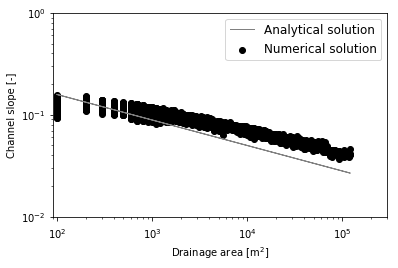

In [5]:
#MAKE SLOPE-AREA PLOT

# assign area_array and slope_array
area_array = model.grid.at_node['drainage_area'][(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >10)&(model.grid.node_y<980)]
slope_array = model.grid.at_node['topographic__steepest_slope'][(model.grid.node_x > 10)&(model.grid.node_x < 1580)&(model.grid.node_y >10)&(model.grid.node_y<980)]

# instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

# create an array for the detachment-limited analytical solution
u = params['outlet_lowering_rate']# m/yr, uplift or baselevel lowering rate
k = params['K_sp'] # fluvial erodibility
m = params['m_sp'] # discharge exponent
n = params['n_sp'] # slope exponent

# calculate analytical slope from area field
analytical_slope_array = np.power((u / k), 1 / n) * np.power(area_array, -m/n)

# plot the analytical solution
slope_area.plot(area_array, analytical_slope_array, linestyle='-',
                color='grey', linewidth = 1, label = 'Analytical solution')

# plot the data
slope_area.scatter(area_array, slope_array, marker='o', c='k', 
                   label = 'Numerical solution') 
                   
# make axes log and set limits
slope_area.set_xscale('log')
slope_area.set_yscale('log')

slope_area.set_xlim(9*10**1, 3*10**5)
slope_area.set_ylim(1e-2, 1e0)

# set x and y labels
slope_area.set_xlabel(r'Drainage area [m$^2$]')
slope_area.set_ylabel('Channel slope [-]')
slope_area.legend(scatterpoints=1,prop={'size':12})
slope_area.tick_params(axis='x', which='major', pad=7)

# save out an output figure
output_figure = os.path.join('output_figures/maintext_variable_m_slope_area.eps')
fig.savefig(output_figure, bbox_inches='tight', dpi=1000) # save figure

In [6]:
#export NetCDF for Paraview image of topography
output_file = os.path.join('output_netcdfs/maintext_variable_m.nc')
write_netcdf(output_file, model.grid, format='NETCDF3_64BIT', names='topographic__elevation')

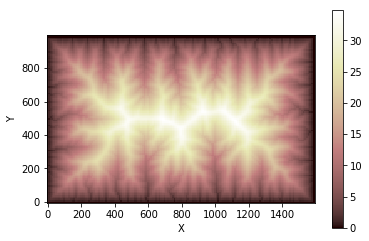

In [7]:
# make a plot of the final steady state topography
imshow_grid(model.grid, 'topographic__elevation')